# SETUP AND DATA PREP

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:

import gspread

from oauth2client import client
from oauth2client.service_account import ServiceAccountCredentials

# from cessi.download_data import get_data
import pandas as pd
import requests

def connect_to_db(credentials):

    scope = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
    ]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials,scope)
    client = gspread.authorize(creds)

    return client
  
def connect():

  credentials = 'creds.json'
  client = connect_to_db(credentials)

  return client


def get_cessi_data(client):

  cessi_data_sheet = client.open('cessi_data_file').sheet1
  cessi_data = pd.DataFrame(cessi_data_sheet.get_all_records())

  cessi_data['Date'] = pd.to_datetime(cessi_data['Date'],format = '%b/%d/%Y')
  cessi_data = cessi_data.iloc[12:] # to match both of the data ( some of the data in cessi is missing (24-4-2020 and 25-4-2020))
  
  return cessi_data

def get_mobility_data(client):

  mobility_sheet = client.open('MH_mobility').worksheets()

  mobility_data_sheet_2020 = mobility_sheet[1]
  mobility_data_sheet_2021 = mobility_sheet[0]

  mobility_data_2020 = pd.DataFrame(mobility_data_sheet_2020.get_all_records())
  mobility_data_2021 = pd.DataFrame(mobility_data_sheet_2021.get_all_records())

  mobility_data = pd.concat([mobility_data_2020,mobility_data_2021],axis=0)
  mobility_data = mobility_data[mobility_data['sub_region_2'] == 'Pune']
  mobility_data = mobility_data.drop(columns = ['sub_region_1','sub_region_2'])
  
  mobility_data = mobility_data.iloc[71:]
  mobility_data['date'] = pd.to_datetime(mobility_data['date'],format = '%Y-%m-%d')

  return mobility_data


def get_data():

  client = connect()

  cessi_data = get_cessi_data(client)
  mobility_data = get_mobility_data(client)
  
  columns = list(cessi_data.columns) + list(mobility_data.columns)
  final_data = pd.DataFrame(columns = columns)

  for ( _ , row1 ) , (_ , row2) in zip(cessi_data.iterrows(),mobility_data.iterrows()):
    row = list(row1) + list(row2)
    final_data.loc[len(final_data.index)] = row

  final_data.drop(columns = ['date'],inplace = True)

  return final_data



In [3]:
df = get_data()
date_time = pd.to_datetime(df.pop('Date'), format='%d/%m/%Y')
df

,dailysamples,dailyconfirmed,dailyrecovered,dailydeceased,totalcritical,totalsamples,totalconfirmed,totalhospital,totalrecovered,totaldeceased,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,367,72,6,5,44,7230,1139,768,165,72,-92,-74,-85,-78,-60,29
1,445,78,11,3,49,7675,1217,821,176,75,-91,-69,-79,-77,-81,43
2,510,122,27,2,73,8185,1339,919,203,79,-91,-68,-80,-76,-81,43
3,673,93,27,2,70,8858,1432,980,230,81,-91,-68,-80,-76,-81,42
4,340,86,44,7,70,9198,1518,1022,274,85,-91,-69,-80,-76,-81,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,6398,90,93,0,451,3707180,507055,869,497102,9104,-20,21,-25,8,0,9
588,5878,81,88,1,96,3713058,507136,841,497190,9105,-13,22,-11,20,4,6
589,4426,38,88,0,84,3717484,507174,791,497278,9105,-12,28,-17,11,-22,12
590,4911,74,92,0,79,3722395,507248,773,497370,9105,-11,26,-16,13,-22,11


In [4]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

### data division 80% train , 10 % val, 10% test

In [5]:

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.90):]

num_features = df.shape[1]

### NOrmalize


In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Data windowing

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
def plot(self, model=None, plot_col='dailyconfirmed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [12]:
days_count = 30 #24 days input
data_window = WindowGenerator(
    input_width=days_count,
    label_width=1,
    shift=1,
    label_columns=['dailyconfirmed'])

data_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['dailyconfirmed']

## Model development and tranning 

In [58]:


def compile_and_fit(model, window, patience=2,MAX_EPOCHS = 50):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [14]:
val_performance = {}
performance = {}

# SINGLE OUTPUT

### Linear

In [15]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

In [16]:
history = compile_and_fit(linear, data_window)

val_performance['Linear'] = linear.evaluate(data_window.val)
performance['Linear'] = linear.evaluate(data_window.test, verbose=0)

Epoch 1/50
14/14 [==============================] - 1s 17ms/step - loss: 2.5663 - mean_absolute_error: 1.3124 - val_loss: 7.5277 - val_mean_absolute_error: 2.7095
Epoch 2/50
14/14 [==============================] - 0s 7ms/step - loss: 2.3651 - mean_absolute_error: 1.2598 - val_loss: 6.6930 - val_mean_absolute_error: 2.5516
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 2.1807 - mean_absolute_error: 1.2070 - val_loss: 5.9089 - val_mean_absolute_error: 2.3943
Epoch 4/50
14/14 [==============================] - 0s 8ms/step - loss: 2.0156 - mean_absolute_error: 1.1562 - val_loss: 5.2118 - val_mean_absolute_error: 2.2454
Epoch 5/50
14/14 [==============================] - 0s 8ms/step - loss: 1.8731 - mean_absolute_error: 1.1104 - val_loss: 4.6089 - val_mean_absolute_error: 2.1087
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 1.7436 - mean_absolute_error: 1.0655 - val_loss: 4.0957 - val_mean_absolute_error: 1.9854
Epoch 7/50
14/14 [=========

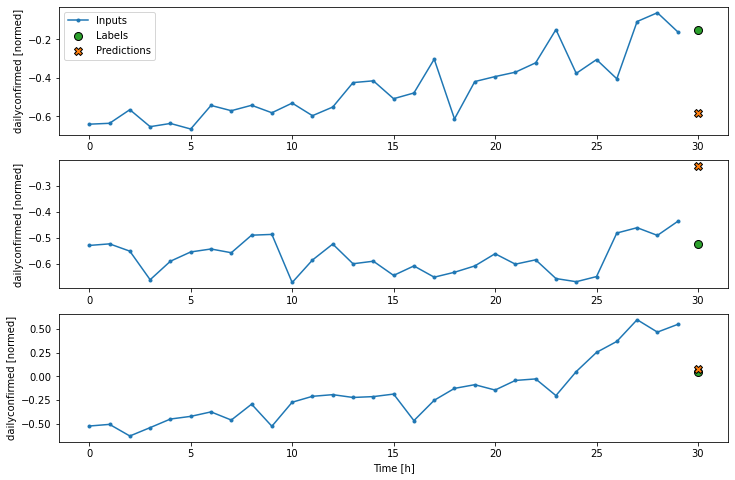

In [17]:
data_window.plot(linear)

## Dense

In [18]:
Dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [19]:
print('Input shape:', data_window.example[0].shape)
print('Output shape:', Dense(data_window.example[0]).shape)

Input shape: (32, 30, 16)
Output shape: (32, 1, 1)


In [20]:
history = compile_and_fit(Dense, data_window)

IPython.display.clear_output()
val_performance['Dense'] = Dense.evaluate(data_window.val)
performance['Dense'] = Dense.evaluate(data_window.test, verbose=0)

1/1 [==============================] - 0s 52ms/step - loss: 0.0416 - mean_absolute_error: 0.1852


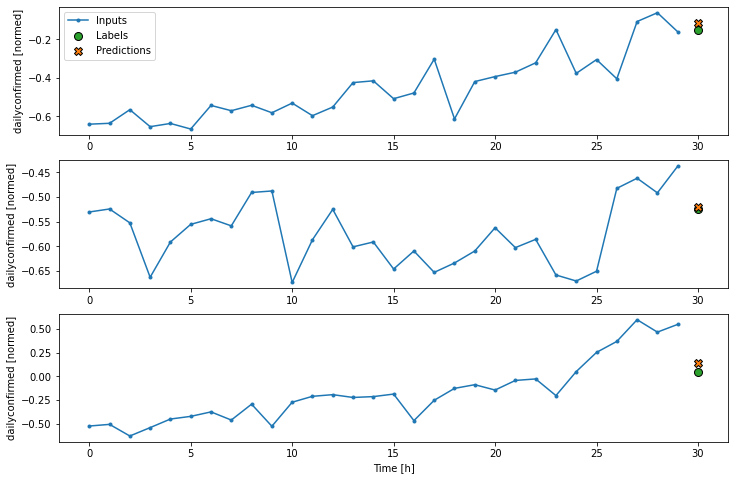

In [21]:
data_window.plot(Dense)

## CNN

In [22]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(30,),
                           activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [23]:
print("Conv model on `conv_window`")
print('Input shape:', data_window.example[0].shape)
print('Output shape:', conv_model(data_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 16)
Output shape: (32, 1, 1)


In [24]:
history = compile_and_fit(conv_model, data_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(data_window.val)
performance['Conv'] = conv_model.evaluate(data_window.test, verbose=0)

1/1 [==============================] - 0s 55ms/step - loss: 0.0099 - mean_absolute_error: 0.0828


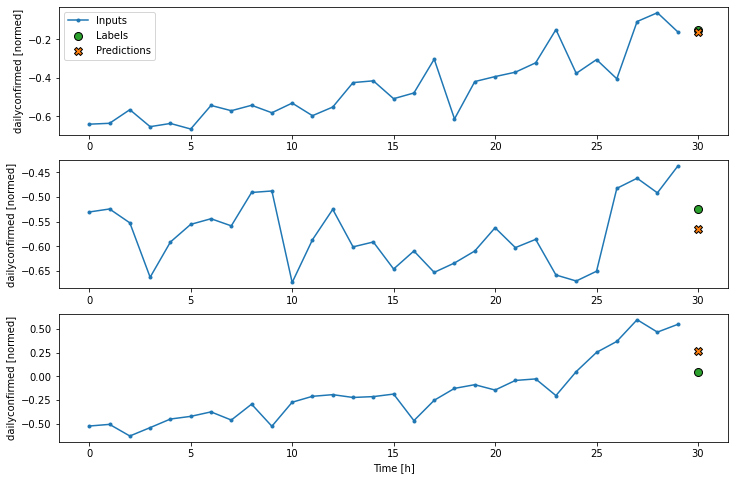

In [25]:
data_window.plot(conv_model)

##LSTM RNN

In [26]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),

])

In [27]:
print('Input shape:', data_window.example[0].shape)
print('Output shape:', lstm_model(data_window.example[0]).shape)

Input shape: (32, 30, 16)
Output shape: (32, 1, 1)


In [28]:
history = compile_and_fit(lstm_model, data_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(data_window.val)
performance['LSTM'] = lstm_model.evaluate(data_window.test, verbose=0)

1/1 [==============================] - 0s 72ms/step - loss: 0.0030 - mean_absolute_error: 0.0497


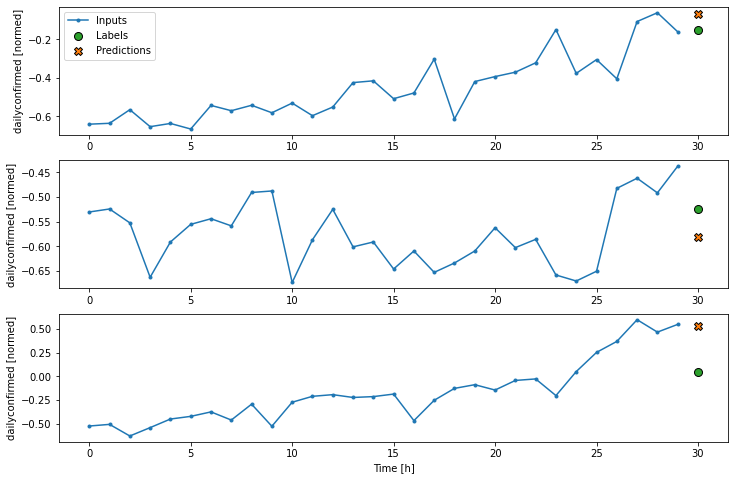

In [29]:
data_window.plot(lstm_model)

## PERFORMANCE

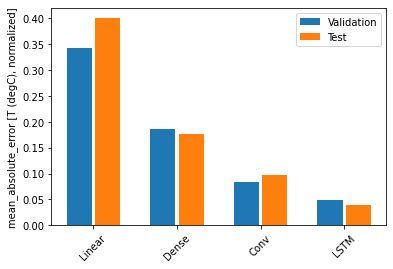

In [30]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [31]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Linear      : 0.3995
Dense       : 0.1769
Conv        : 0.0965
LSTM        : 0.0392


#MULTI OUTPUT

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36]
Label column name(s): None

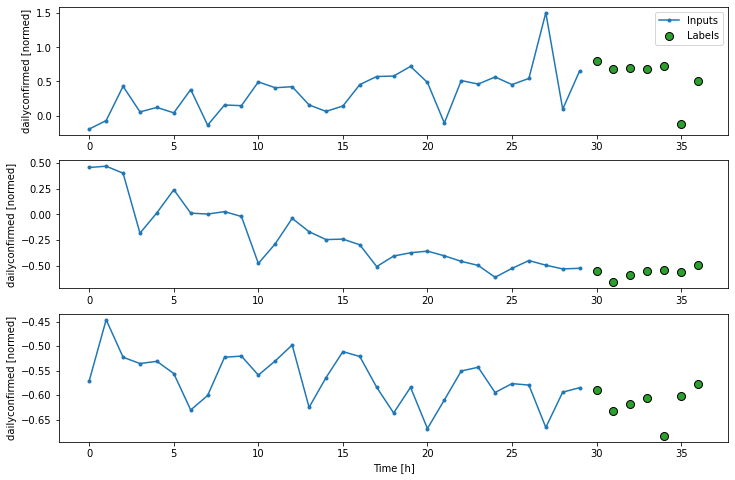

In [59]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [60]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [77]:
feedback_model = FeedBack(units=256, out_steps=OUT_STEPS)

In [78]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [79]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 16])

In [80]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [81]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 16)


In [82]:
multi_val_performance = {}
multi_performance = {}

1/1 [==============================] - 0s 75ms/step - loss: 0.3781 - mean_absolute_error: 0.4933


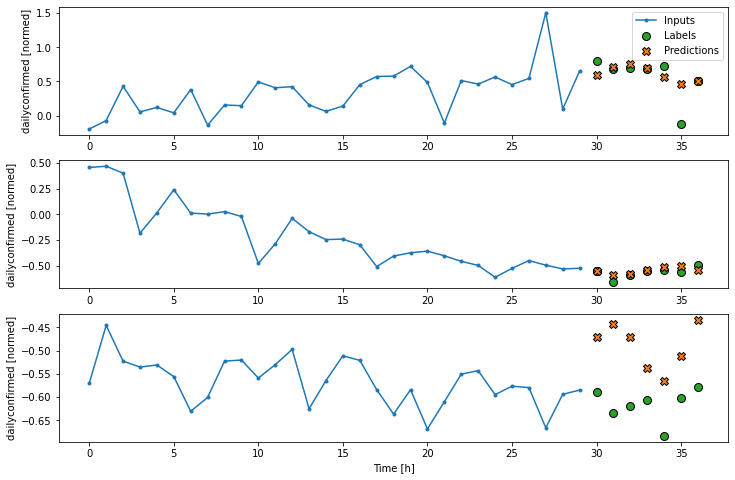

In [86]:
history = compile_and_fit(feedback_model, multi_window,MAX_EPOCHS = 500,patience=2)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance

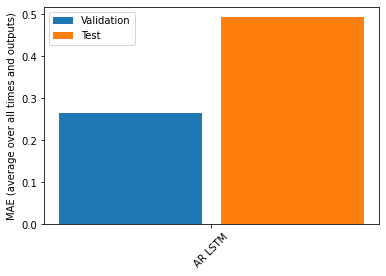

In [87]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [88]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

AR LSTM : 0.4933
